## World Happiness Classification Competition

This machine learning project utilizes classification modeling techniques to predict a country's happiness level as part of a class project. This project uses AI Model Share compare prediction results with other students in the class.

## 0. Global Definitions: Libraries and Dataset 

In [ ]:
# load libraries
import aimodelshare as ai
from aimodelshare import download_data
from aimodelshare.aimsonnx import model_to_onnx
from aimodelshare.aws import set_credentials

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from skl2onnx.common.data_types import FloatTensorType


import numpy as np
import warnings
import plotly.express as px
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

In [ ]:
# load helper functions
from preprocessor import preprocessor

In [ ]:
# Get competition data
download_data('public.ecr.aws/y2e2a1d6/world_happiness_competition_data-repository:latest') 
new_data

ModuleNotFoundError: No module named 'aimodelshare'

## 1. Get data in and set up X_train, X_test, y_train objects

In [ ]:
# Load data
X_train = pd.read_csv('world_happiness_competition_data/X_train.csv')
X_test = pd.read_csv('world_happiness_competition_data/X_test.csv')
y_train = pd.read_csv('world_happiness_competition_data/y_train.csv')
y_train_labels = y_train.idxmax(axis=1)

new_data = pd.concat([X_train,y_train],axis=1)
new_data

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks,Average,High,Low,Very High,Very Low
0,Saudi Arabia,1.403,1.357,0.795,0.439,0.080,0.132,Saudi Arabia,Asia,Western Asia,173.000000,0,0,0,1,0
1,Georgia,0.886,0.666,0.752,0.346,0.043,0.164,Georgia,Asia,Western Asia,18.000000,0,0,1,0,0
2,Guinea,0.380,0.829,0.375,0.332,0.207,0.086,Guinea,Africa,Sub-Saharan Africa,3.000000,0,0,1,0,0
3,Lithuania,1.238,1.515,0.818,0.291,0.043,0.042,Lithuania,Europe,Northern Europe,125.611111,0,1,0,0,0
4,Netherlands,1.396,1.522,0.999,0.557,0.322,0.298,Netherlands,Europe,Western Europe,1.000000,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Libya,1.044,1.303,0.673,0.416,0.133,0.152,Libya,Africa,Northern Africa,1448.000000,1,0,0,0,0
100,Albania,0.947,0.848,0.874,0.383,0.178,0.027,Albania,Europe,Southern Europe,9.000000,0,0,1,0,0
101,United Kingdom,1.333,1.538,0.996,0.450,0.348,0.278,United Kingdom,Europe,Northern Europe,339.000000,0,0,0,1,0
102,China,1.029,1.125,0.893,0.521,0.058,0.100,China,Asia,Eastern Asia,37.000000,1,0,0,0,0


In [ ]:
# display very low happiness countries
fig = px.box(new_data, x="Very Low", y="Perceptions of corruption")
fig.show()

In [ ]:
# display low happiness countries
fig = px.box(new_data, x="Low", y="Perceptions of corruption")
fig.show()

In [ ]:
# display average happiness countries
fig = px.box(new_data, x="Average", y="Perceptions of corruption")
fig.show()

In [ ]:
# display high happiness countries
fig = px.box(new_data, x="High", y="Perceptions of corruption")
fig.show()

In [ ]:
# display very high happiness countries
fig = px.box(new_data, x="Very High", y="Perceptions of corruption")
fig.show()
# we can notice here that there has a clear relationship between "very high happiness" and "perception of corruption"

##2.   Preprocess data using Sklearn Column Transformer/ Write and Save Preprocessor function


In [ ]:
# Create the preprocessing pipelines for both numeric and categorical data

numeric_features = X_train.drop(['Country or region', 'name', 'region', 'sub-region'], axis=1)
numeric_features=numeric_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region', 'sub-region']

# Replacing missing values with Modal value and then one hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Fit preprocessor object
preprocess=preprocessor.fit(X_train) 

In [ ]:
# check shape of X data after preprocessing it using our new function
preprocessor(X_train).shape

(104, 26)

In [ ]:
warnings.filterwarnings("ignore")
X_train_2 = X_train[[ 'GDP per capita', 'Social support',
       'Healthy life expectancy', 'Freedom to make life choices', 'Generosity','Perceptions of corruption', 'Terrorist_attacks']]

clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=20).fit(X_train_2, y_train_labels)
print("The training dataset has score: {:.2f}".format(clf.score(X_train_2, y_train_labels)))

The training dataset has score: 0.62


In [ ]:
# display coefficients of logistic regression results
pd.DataFrame(clf.coef_[0], 
             X_train_2.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
Healthy life expectancy,1.184998
GDP per capita,0.783528
Social support,0.073484
Terrorist_attacks,0.002048
Generosity,-1.001025
Perceptions of corruption,-1.242382
Freedom to make life choices,-1.283487


Feature: 0, Score: 0.78353
Feature: 1, Score: 0.07348
Feature: 2, Score: 1.18500
Feature: 3, Score: -1.28349
Feature: 4, Score: -1.00102
Feature: 5, Score: -1.24238
Feature: 6, Score: 0.00205


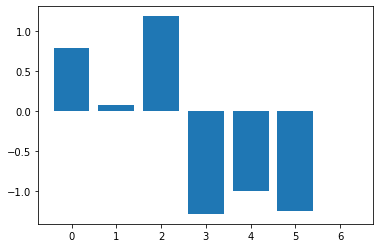

In [ ]:
# get importance
importance = clf.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
 
# plot feature importance
import matplotlib.pyplot as plt
plt.bar([x for x in range(len(importance))], importance)
plt.show()

##3. Fit model on preprocessed data and save preprocessor function and model 


In [ ]:
# fit to  k-nearest neighbors classifier
knn_param = {'n_neighbors': np.arange(1, 15, 2)}
knn = GridSearchCV(KNeighborsClassifier(), knn_param, cv=10)
knn.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.

print("The best parameters for KNN Classifer is: {}".format(knn.best_params_))
print("The best mean cross-validation score: {:.3f}".format(knn.best_score_))
print("KNN Classifier train score: {:.4f}".format(knn.score(preprocessor(X_train), y_train_labels)))

The best parameters for KNN Classifer is: {'n_neighbors': 9}
The best mean cross-validation score: 0.676
KNN Classifier train score: 0.7404


In [ ]:
# fit to svm classifier
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
svm = GridSearchCV(SVC(), param_grid,cv = 5)
svm.fit(preprocessor(X_train), y_train_labels)

print("The best parameters for KNN Classifer is: {}".format(svm.best_params_))
print("The best mean cross-validation score: {:.3f}".format(svm.best_score_))
print("SVM Classifier train score: {:.4f}".format(svm.score(preprocessor(X_train), y_train_labels)))

The best parameters for KNN Classifer is: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
The best mean cross-validation score: 0.702
SVM Classifier train score: 0.8173


In [ ]:
# fit to decision tree classifier
grid = {'max_depth':np.arange(1,20),
        'min_samples_split':range(1,20),
        'min_samples_leaf':range(1,10)}

tree_grid = GridSearchCV(DecisionTreeClassifier(),param_grid =grid, cv = 5)
decision_tree = tree_grid.fit(preprocessor(X_train), y_train_labels)

print("The best parameters for KNN Classifer is: {}".format(decision_tree.best_params_))
print("The best mean cross-validation score: {:.3f}".format(decision_tree.best_score_))
print("Decision Classifier train score: {:.4f}".format(decision_tree.score(preprocessor(X_train), y_train_labels)))


# decision tree model has the best performance with max depth of 16, minimum sample leaves of 1 and minimum sample split of 11

The best parameters for KNN Classifer is: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 11}
The best mean cross-validation score: 0.644
Decision Classifier train score: 0.8365


#### Save preprocessor function to local "preprocessor.zip" file

In [ ]:
# export preprocessor
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


#### Save model to local ".onnx" file

In [ ]:
# Check how many preprocessed input features are there
feature_count=preprocessor(X_test).shape[1] # Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(decision_tree, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

## 4. Generate predictions from X_test data and submit model to competition


In [ ]:
# Set credentials using modelshare.org username/password

# This is the unique rest api that powers this World Happiness Classification Playground -- make sure to update the apiurl for new competition deployments
apiurl="https://c3maq947kb.execute-api.us-east-1.amazonaws.com/prod/m"

set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Instantiate Competition
mycompetition= ai.Competition(apiurl)

In [ ]:
# Submit Model 1: 

# -- Generate predicted values (Model 1)
prediction_labels = decision_tree.predict(preprocessor(X_test))

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): yz4008
Provide any useful notes about your model (optional): HW#1

Your model has been submitted as model version 315

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1289


In [ ]:
# Get leaderboard to explore current best model architectures

# Get raw data in pandas data frame
data = mycompetition.get_leaderboard()

# Stylize leaderboard data
mycompetition.stylize_leaderboard(data)

## 5. Repeat submission process to improve place on leaderboard


In [ ]:
# Train and submit model 2 using same preprocessor (note that you could save a new preprocessor, but we will use the same one for this example).
model_2 = RandomForestClassifier(n_estimators=100, max_depth=5)
model_2.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.
model_2.score(preprocessor(X_train), y_train_labels) # Fit score, 0-1 scale.

0.9615384615384616

In [ ]:
# Save sklearn model to local ONNX file
feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(model_2, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
# Submit Model 2: 

#-- Generate predicted y values (Model 2)
prediction_labels = model_2.predict(preprocessor(X_test))

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model2.onnx",
                                 prediction_submission=prediction_labels,
                                 preprocessor_filepath="preprocessor.zip")

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 3

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1289


In [ ]:
# Compare two or more models
data=mycompetition.compare_models([2,3], verbose=1)
mycompetition.stylize_compare(data)

,param_name,default_value,model_version_2,model_version_3
0,bootstrap,True,True,True
1,ccp_alpha,0.000000,0.000000,0.000000
2,class_weight,None,None,None
3,criterion,gini,gini,gini
4,max_depth,None,3,5
5,max_features,auto,auto,auto
6,max_leaf_nodes,None,None,None
7,max_samples,None,None,None
8,min_impurity_decrease,0.000000,0.000000,0.000000
9,min_impurity_split,None,None,None


In [ ]:
# Submit a third model using GridSearchCV

param_grid = {'n_estimators': np.arange(100, 300, 500),'max_depth':[1, 3, 5]} #np.arange creates sequence of numbers for each k value

gridmodel = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=10)

#use meta model methods to fit score and predict model:
gridmodel.fit(preprocessor(X_train), y_train_labels)

#extract best score and parameter by calling objects "best_score_" and "best_params_"
print("best mean cross-validation score: {:.3f}".format(gridmodel.best_score_))
print("best parameters: {}".format(gridmodel.best_params_))


best mean cross-validation score: 0.637
best parameters: {'max_depth': 5, 'n_estimators': 100}


In [ ]:
# Save sklearn model to local ONNX file

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(gridmodel, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("gridmodel.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
# Submit Model 3: 

# -- Generate predicted values
prediction_labels = gridmodel.predict(preprocessor(X_test))

# Submit to Competition Leaderboard
mycompetition.submit_model(model_filepath = "gridmodel.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 4

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1289


In [ ]:
# Get leaderboard

data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,dense_layers,softmax_act,relu_act,loss,optimizer,model_config,memory_size,username,version
0,50.00%,50.11%,55.99%,50.83%,sklearn,False,False,RandomForestClassifier,nan,nan,nan,nan,nan,nan,nan,"{'bootstrap': True, 'ccp_alpha...",nan,AdvProjectsinML,3
1,46.15%,46.02%,51.79%,46.83%,sklearn,False,False,RandomForestClassifier,nan,nan,nan,nan,nan,nan,nan,"{'bootstrap': True, 'ccp_alpha...",nan,AdvProjectsinML,4
3,44.23%,43.28%,49.76%,46.33%,sklearn,False,False,RandomForestClassifier,nan,nan,nan,nan,nan,nan,nan,"{'bootstrap': True, 'ccp_alpha...",nan,AdvProjectsinML,2
4,46.15%,45.04%,49.44%,45.85%,keras,False,True,Sequential,4.000000,10373.000000,4.000000,1.000000,3.000000,str,SGD,"{'name': 'sequential', 'layers...",1369568.000000,AdvProjectsinML,1


In [ ]:
# Compare two or more models

data=mycompetition.compare_models([3,4], verbose=1)
mycompetition.stylize_compare(data)

,param_name,default_value,model_version_3,model_version_4
0,bootstrap,True,True,True
1,ccp_alpha,0.000000,0.000000,0.000000
2,class_weight,None,None,None
3,criterion,gini,gini,gini
4,max_depth,None,5,5
5,max_features,auto,auto,auto
6,max_leaf_nodes,None,None,None
7,max_samples,None,None,None
8,min_impurity_decrease,0.000000,0.000000,0.000000
9,min_impurity_split,None,None,None


In [ ]:
#Example code to fit model:

model = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,
    max_depth=1, random_state=0).fit(preprocessor(X_train), y_train_labels)
model.score(preprocessor(X_train), y_train_labels)

# Save sklearn model to local ONNX file

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(model, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

# -- Generate predicted values 
prediction_labels = model.predict(preprocessor(X_test))

# Submit model to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)


Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 5

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1289


In [ ]:
# Or you can experiment with deep learning models: 
feature_count=preprocessor(X_train).shape[1] #count features in input data

keras_model = Sequential()
keras_model.add(Dense(128, input_dim=feature_count, activation='relu'))
keras_model.add(Dense(64, activation='relu'))
keras_model.add(Dense(64, activation='relu'))
keras_model.add(Dense(32, activation='relu'))

keras_model.add(Dense(5, activation='softmax')) 
                                            
# Compile model
keras_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
keras_model.fit(preprocessor(X_train), y_train, ## Note that keras models require a one-hot-encoded y_train object
               batch_size = 20, 
               epochs = 300, validation_split=0.25)  

In [ ]:
# Save keras model to ONNX file 

onnx_model = model_to_onnx(keras_model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
# Submit keras model: 

# -- Generate predicted y values
# Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=keras_model.predict(preprocessor(X_test)).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 6

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1289


In [ ]:
# Check leaderboard 

data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,dense_layers,softmax_act,relu_act,loss,optimizer,model_config,memory_size,username,version
0,53.85%,53.62%,57.92%,53.67%,sklearn,False,False,GradientBoostingClassifier,nan,nan,nan,nan,nan,nan,nan,"{'ccp_alpha': 0.0, 'criterion'...",nan,AdvProjectsinML,5
1,51.92%,51.35%,54.37%,52.20%,keras,False,True,Sequential,5.000000,18117.000000,5.000000,1.000000,4.000000,str,SGD,"{'name': 'sequential', 'layers...",1461312.000000,AdvProjectsinML,6
2,50.00%,50.11%,55.99%,50.83%,sklearn,False,False,RandomForestClassifier,nan,nan,nan,nan,nan,nan,nan,"{'bootstrap': True, 'ccp_alpha...",nan,AdvProjectsinML,3
3,46.15%,46.02%,51.79%,46.83%,sklearn,False,False,RandomForestClassifier,nan,nan,nan,nan,nan,nan,nan,"{'bootstrap': True, 'ccp_alpha...",nan,AdvProjectsinML,4
5,44.23%,43.28%,49.76%,46.33%,sklearn,False,False,RandomForestClassifier,nan,nan,nan,nan,nan,nan,nan,"{'bootstrap': True, 'ccp_alpha...",nan,AdvProjectsinML,2
6,46.15%,45.04%,49.44%,45.85%,keras,False,True,Sequential,4.000000,10373.000000,4.000000,1.000000,3.000000,str,SGD,"{'name': 'sequential', 'layers...",1369568.000000,AdvProjectsinML,1
